### This will be in the prepare module
    _Check for and remove duplicates by customer_id. - None
    
    _Remove redundant columns: payment_type_id, internet_service_type_id, contract_type_id, & customer_id. - Completed
        -Used the following to drop redundant columns
        -df = df.drop(['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id'], axis = 1)
        -df.head(2)
    
    _Encode payment_type(Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)), internet_service_type(DSL, Fiber, None), contract_type(Month-to-month, One year, Two year), gender(male/female), partner(yes/no), multiple_line(yes/no), device_protection(yes/no), tech_support(yes/no), streaming_tv(yes/no), streaming_movies(yes/no), paperless_billing, & churn (yes/no).
    - gender is male(1) or not male(0)
    - yes(1) no(0)
    - payment, contract and service types (True = 1) (Fales = 0)
    
    _Check for nulls and fill (Fill in total_charges' blanks with 0). - Completed
        -#find empty values. Tried isna, isnull, notna, notnull but did not shown any matches.
            -df.eq(' ').sum()
        -Used .replace to empty values with a 0 in total charges.
            -df = df.replace({'total_charges': ' '}, 0)
            -df.head()

    _Convert total_charges to float64. - Completed
        -#convert 'total_charges' to float and validate change.
        - df['total_charges'] = df['total_charges'].astype(float)
        - df.dtypes
    
    _Replace 'No phone service' & 'No internet service' with 'No'. - Completed
        -df.replace(to_replace = 'No internet service', value = 'No')
        -df.replace(to_replace = 'No phone service', value = 'No')

In [1]:
#libraries
import get_db
import explore
import prepare
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import graphviz
from graphviz import Graph

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Working code for project

# Acquire

In [2]:
df = get_db.get_telco_data()
df.head(1)

,payment_type_id,payment_type,internet_service_type_id,internet_service_type,contract_type_id,contract_type,customer_id,gender,senior_citizen,partner,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn
0,1,Electronic check,1,DSL,1,Month-to-month,0015-UOCOJ,Female,1,No,...,Yes,No,No,No,No,No,Yes,48.2,340.35,No


In [ ]:
#data summarization
df.describe(include='all').T

In [ ]:
df.info()

#### Initial visualization

In [ ]:
#plot charts on acquired data prior to data cleaning.
num_cols = df.columns[[df[col].dtype == 'int64' for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [ ]:
#value counts on acquired data prior to data cleaning.
obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
for col in obj_cols:
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True, dropna=False))
    print('----------------------')

#### From above:
    - From above plot charts and column value counts we find the following have no weight on churn rate and will be dropped:
        - Remove 'phone_service', 'internet_service', 'senior_citizen', 'paperless' & 'tech_support' (irrelevant)

# Clean

In [3]:
#added above to the prepare module.
df = prepare.clean_data(df)
df.head()

,tenure,monthly_charges,dsl,fiber,no_internet,m2m,churned,partner,dependents,phone_service,tech_support,auto_payment
0,7,48.20,1,0,0,1,0,0,0,1,0,1
1,1,25.10,1,0,0,1,1,0,0,0,0,1
2,2,49.25,1,0,0,1,1,0,0,1,0,1
3,64,81.25,1,0,0,0,0,0,0,1,1,1
4,6,50.35,1,0,0,1,0,1,0,1,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tenure           7043 non-null   int64  
 1   monthly_charges  7043 non-null   float64
 2   dsl              7043 non-null   int64  
 3   fiber            7043 non-null   int64  
 4   no_internet      7043 non-null   int64  
 5   m2m              7043 non-null   int64  
 6   churned          7043 non-null   int64  
 7   partner          7043 non-null   int64  
 8   dependents       7043 non-null   int64  
 9   phone_service    7043 non-null   int64  
 10  tech_support     7043 non-null   int64  
 11  auto_payment     7043 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 715.3 KB


# Split your data into train, validate, and test samples.

In [5]:
train, validate, test = prepare.train_validate_test_split(df, 'churned')

In [6]:
print(train.shape, validate.shape, test.shape)

(3943, 12) (1691, 12) (1409, 12)


In [7]:
# create X & y version of train, where y is a series with just the target variable and X are all the features.
X_train = train.drop(columns=["churned"])
y_train = train.churned

X_validate = validate.drop(columns=["churned"])
y_validate = validate.churned

X_test = test.drop(columns=["churned"])
y_test = test.churned

In [8]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.73


# Exploratory

#### Univariate Stats

In [9]:
cat_vars = ['churned','tenure', 'dsl', 'fiber', 'no_internet', 'm2m', 'partner', 'dependents',
            'phone_service', 'tech_support', 'auto_payment']
quant_vars = ['monthly_charges']

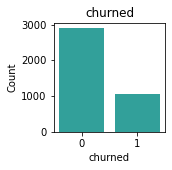

   churned  Count  Percent
0        0   2897    73.47
1        1   1046    26.53
_________________________________________________________________


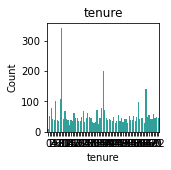

    tenure  Count  Percent
1        9    341     8.65
72      36    201     5.10
2       64    141     3.58
3        8    108     2.74
4        5    102     2.59
..     ...    ...      ...
31      30     29     0.74
59      63     28     0.71
36      33     26     0.66
44      14     24     0.61
0        0      8     0.20

[73 rows x 3 columns]
_________________________________________________________________


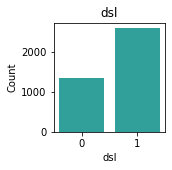

   dsl  Count  Percent
0    1   2592    65.74
1    0   1351    34.26
_________________________________________________________________


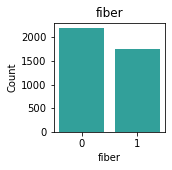

   fiber  Count  Percent
0      0   2191    55.57
1      1   1752    44.43
_________________________________________________________________


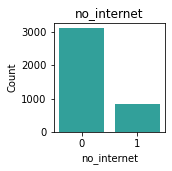

   no_internet  Count  Percent
0            0   3103     78.7
1            1    840     21.3
_________________________________________________________________


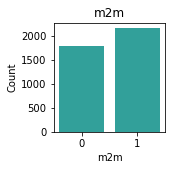

   m2m  Count  Percent
1    1   2160    54.78
0    0   1783    45.22
_________________________________________________________________


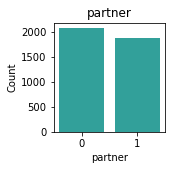

   partner  Count  Percent
0        0   2066     52.4
1        1   1877     47.6
_________________________________________________________________


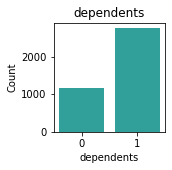

   dependents  Count  Percent
0           1   2763    70.07
1           0   1180    29.93
_________________________________________________________________


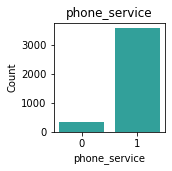

   phone_service  Count  Percent
1              1   3584     90.9
0              0    359      9.1
_________________________________________________________________


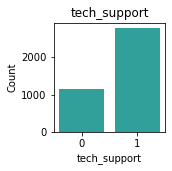

   tech_support  Count  Percent
0             1   2779    70.48
1             0   1164    29.52
_________________________________________________________________


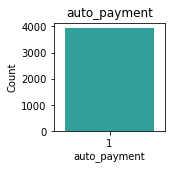

   auto_payment  Count  Percent
1             1   3943    100.0
_________________________________________________________________


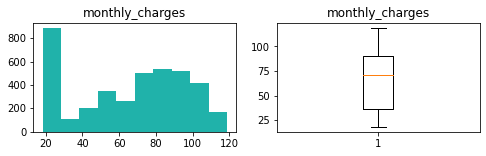

count    3943.000000
mean       65.150710
std        30.030427
min        18.250000
25%        36.475000
50%        70.700000
75%        89.950000
max       118.750000
Name: monthly_charges, dtype: float64


In [10]:
explore.explore_univariate(train, cat_vars, quant_vars)

    _Churn rate
    
        * Churn at its highest at 9 months (341), followed by 36 (201), then 64 months (141)
        * Incentive 12, 36, and 64 customers
            -What type of incentives?
    
    _Dropped 'gender' almost an equal amout of male and female which will not effect churn rate
    
    _Dropped 'online_security', 'device_protection' - small amount of customers use these services.
    
    _Seems like a large amount of people use 'tech_support' - Is churn rate affected by bad service.
    _Large number of customers use streaming services.
    
    

#### Bivariate Stats

In [11]:
cat_vars = cat_vars[1:]

tenure 
_____________________

         chi2       p-value  degrees of freedom
0  673.448746  1.779664e-98                  72

observed:
 churned     0     1   All
tenure                   
0           8     0     8
1         128   213   341
2          61    80   141
3          54    54   108
4          50    52   102
...       ...   ...   ...
69         42     2    44
70         57     5    62
71         96     3    99
72        197     4   201
All      2897  1046  3943

[74 rows x 3 columns]

expected:
              0          1
0     5.877758   2.122242
1   250.539437  90.460563
2   103.595486  37.404514
3    79.349734  28.650266
4    74.941415  27.058585
..         ...        ...
68   38.205427  13.794573
69   32.327669  11.672331
70   45.552625  16.447375
71   72.737256  26.262744
72  147.678671  53.321329

[73 rows x 2 columns]


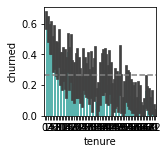


_____________________

dsl 
_____________________

        chi2       p-value  degrees of freedom
0  58.808096  1.738246e-14                   1

observed:
 churned     0     1   All
dsl                      
0        1803   789  2592
1        1094   257  1351
All      2897  1046  3943

expected:
              0           1
0  1904.393609  687.606391
1   992.606391  358.393609


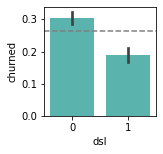


_____________________

fiber 
_____________________

         chi2       p-value  degrees of freedom
0  363.780774  4.230027e-81                   1

observed:
 churned     0     1   All
fiber                    
0        1873   318  2191
1        1024   728  1752
All      2897  1046  3943

expected:
              0           1
0  1609.770987  581.229013
1  1287.229013  464.770987


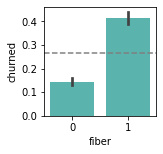


_____________________

no_internet 
_____________________

         chi2       p-value  degrees of freedom
0  202.021901  7.561684e-46                   1

observed:
 churned         0     1   All
no_internet                  
0            2118   985  3103
1             779    61   840
All          2897  1046  3943

expected:
              0           1
0  2279.835405  823.164595
1   617.164595  222.835405


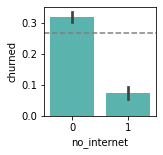


_____________________

m2m 
_____________________

         chi2        p-value  degrees of freedom
0  663.836694  2.187516e-146                   1

observed:
 churned     0     1   All
m2m                      
0        1666   117  1783
1        1231   929  2160
All      2897  1046  3943

expected:
              0           1
0  1310.005326  472.994674
1  1586.994674  573.005326


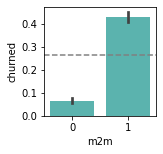


_____________________

partner 
_____________________

        chi2       p-value  degrees of freedom
0  99.970619  1.546747e-23                   1

observed:
 churned     0     1   All
partner                  
0        1379   687  2066
1        1518   359  1877
All      2897  1046  3943

expected:
              0           1
0  1517.931017  548.068983
1  1379.068983  497.931017


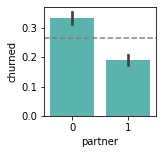


_____________________

dependents 
_____________________

         chi2       p-value  degrees of freedom
0  104.107639  1.916180e-24                   1

observed:
 churned        0     1   All
dependents                  
0           1900   863  2763
1            997   183  1180
All         2897  1046  3943

expected:
              0           1
0  2030.030687  732.969313
1   866.969313  313.030687


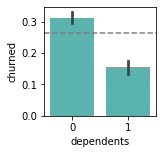


_____________________

phone_service 
_____________________

       chi2   p-value  degrees of freedom
0  0.001099  0.973553                   1

observed:
 churned           0     1   All
phone_service                  
0               264    95   359
1              2633   951  3584
All            2897  1046  3943

expected:
              0           1
0   263.764393   95.235607
1  2633.235607  950.764393


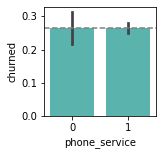


_____________________

tech_support 
_____________________

        chi2       p-value  degrees of freedom
0  96.606082  8.458805e-23                   1

observed:
 churned          0     1   All
tech_support                  
0             1917   862  2779
1              980   184  1164
All           2897  1046  3943

expected:
              0           1
0  2041.786203  737.213797
1   855.213797  308.786203


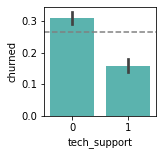


_____________________

auto_payment 
_____________________

   chi2  p-value  degrees of freedom
0   0.0      1.0                   0

observed:
 churned          0     1   All
auto_payment                  
1             2897  1046  3943
All           2897  1046  3943

expected:
         0       1
0  2897.0  1046.0


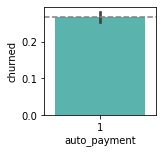


_____________________

monthly_charges 
____________________



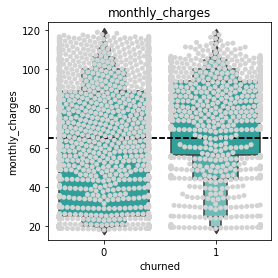

          count       mean        std    min      25%    50%    75%     max
churned                                                                    
0        2897.0  61.850846  31.160324  18.25  25.2000  65.25  89.10  118.75
1        1046.0  74.290010  24.439527  18.95  56.3125  79.55  93.85  118.35 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1176266.5, pvalue=6.775715811014378e-27)

____________________



In [12]:
explore.explore_bivariate(train, 'churned', cat_vars, quant_vars)

    _Churn in one month (213)_
        * Incentive...
            - 1 month free service for m2m customers?
            - Free upgrade service for signing a one_year contract?
            - Free premium service for two year contract?
        * Create a graph that shows churn over tenure.
   
   
    _DROPPED one and two year contract. Numbers have no variance on churn.
    _DROPPED 'multiple_lines' has the similar weight which will not affect churn.
    _Validates drops 'online_security', 'device_protection'
    _DROPPED 'total_charges'. total charges for churn are lower than those who did not churn.
    
    _No partner (687) churn more then couples
    _No dependents (863) churn more than people with dependents.
        * Do singles have an affect on churn? If so, why?
    
    _Lose customers in the first year.
    _Number of fiber (728)  customers who churned.
       * what is about our fiber internet service is making customers churn?
       * Less people churn on DSL then on fiber...possible validation that fiber service needs work.
       * How many fiber customers churn
       
       
    _Can we convert no_internet (985) to internet users?
    
    _Higher number of m2m (929) customers churn.
    
    _Those with phone_service (951) churn.
    
    
    _Customers who do not use 'tech_support' (862) tend to churn.
        * Three options:
            1. Drop column 
            2. Or, keep and recommend to market availability of tech support to customers...
            3. Or is tech support the problem? If so, does tech support need more training.
    
    
    _Customers who are not on auto_payment (780) churn.
    
    _Higher monthly cost have a higher tendency to churn and pay an averge of 74.3 than those who do not 61.85.. Does  higher monthly cost affect churn?
    
    _DROP streaming services. Numbers do not show enough to sway a decision.

#### Multivariate Stats

    _ Need to drop some columns for the multivariate stats.

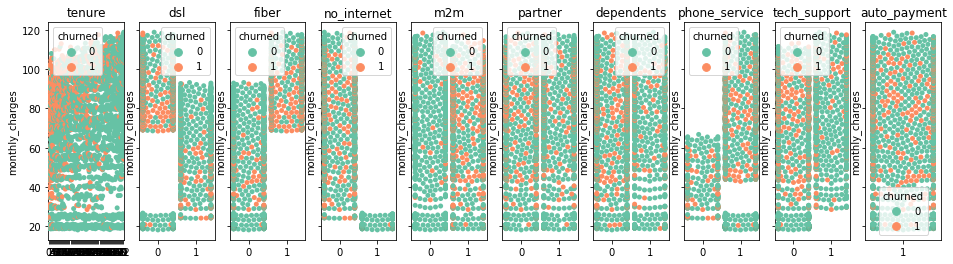

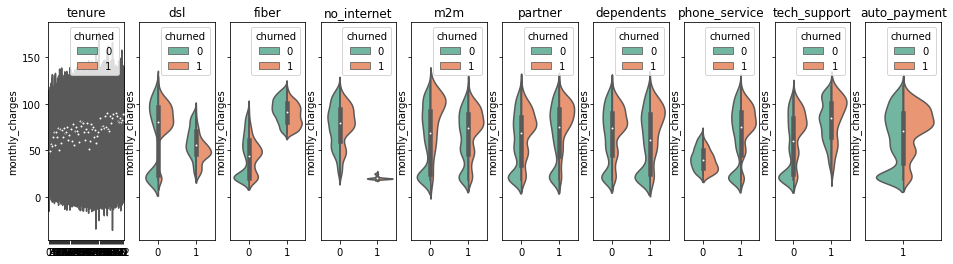

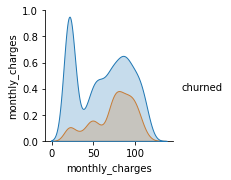

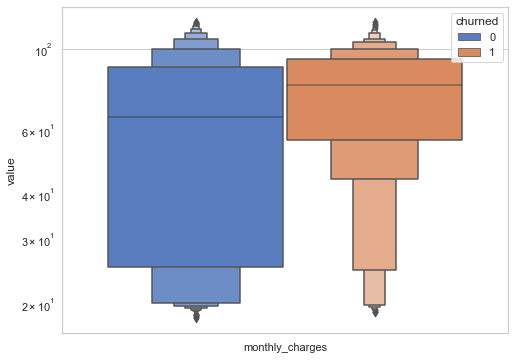

In [13]:
target = 'churned'
explore.explore_multivariate(train, target, cat_vars, quant_vars)

# Modeling

### Decision Tree

In [14]:
#create the model

#for classification you can change the algorithm to gini or entropy (information gain).  
#Default is gini.

model = DecisionTreeClassifier(max_depth=1, random_state=123)

In [15]:
#Fit the model

model = model.fit(X_train, y_train)

In [16]:
#Use the model

# We'll evaluate the model's performance on train, first

y_predictions = model.predict(X_train)

In [17]:
# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.734720,0.0,0.73472,0.367360,0.539813
recall,1.000000,0.0,0.73472,0.500000,0.734720
f1-score,0.847076,0.0,0.73472,0.423538,0.622363
support,2897.000000,1046.0,0.73472,3943.000000,3943.000000


### Random Forrest

In [18]:
#Create the Model
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=1, n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [19]:
#Fit the Model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=123)

In [20]:
#Use the Model
#evaluate the weight
print(rf.feature_importances_)

[0.34380068 0.29317626 0.0160174  0.07653844 0.02559339 0.15587452
 0.0244734  0.02252704 0.01066513 0.03133374 0.        ]


In [21]:
#estimate
y_pred = rf.predict(X_train)

In [22]:
#probability
y_pred_proba = rf.predict_proba(X_train)

In [23]:
#accuracy
print('Accuracy of random forest classifier on training set: {:.2f}'.format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.88


In [24]:
#confusion matrix
print(confusion_matrix(y_train, y_pred))

[[2733  164]
 [ 291  755]]


In [25]:
#Create a classificaiton report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2897
           1       0.82      0.72      0.77      1046

    accuracy                           0.88      3943
   macro avg       0.86      0.83      0.85      3943
weighted avg       0.88      0.88      0.88      3943



In [26]:
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.78


### KNN

In [27]:
#Create the model
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [28]:
#fit the model
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [29]:
#predict/use the model
y_pred = knn.predict(X_train)

In [30]:
#probability
y_pred_proba = knn.predict_proba(X_train)

In [31]:
#accuracy
print('Accuracy of KNN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.84


In [32]:
#confusion matrix
print(confusion_matrix(y_train, y_pred))

[[2669  228]
 [ 410  636]]


In [33]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2897
           1       0.74      0.61      0.67      1046

    accuracy                           0.84      3943
   macro avg       0.80      0.76      0.78      3943
weighted avg       0.83      0.84      0.83      3943



In [34]:
#validate
print('Accuracy of KNN classifier on test set: {:.2f}'.format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.77


# Notes and test code.

In [ ]:
#used to test adding two columns and renaming it.
df['auto_payment'] = df['bank_transfer'] + df['credit_card']

In [ ]:
#split data
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [ ]:
df = prepare.train_validate_test_split(df, 'churned')

In [ ]:
#split into train, validate, test
train, validate, test = train_validate_test_split()
train.head(2)

In [ ]:
print(train.shape, validate.shape, test.shape)

In [ ]:
df.info()

In [ ]:
#Looking for unique values in "types"
df.contract_type.unique()

In [ ]:
#check to see if there are any duplicates by 'customer_id'
df.duplicated(subset = 'internet_service').unique()

In [ ]:
#find empty values. Tried isna, isnull, notna, notnull but did not shown any matches.
df.eq(' ').sum()

In [ ]:
#replaces empty values with a 0 in total charges.
df = df.replace({'total_charges': ' '}, 0)
df.head()

In [ ]:
#verify empty values in total_charges have been replace.
df.eq(' ').sum()

In [ ]:
df = df.drop(['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id'], axis = 1)
df.head(2)

In [ ]:
df.shape

In [ ]:
#convert 'total_charges' to float and validate change.
df['total_charges'] = df['total_charges'].astype(float)
df.dtypes

In [ ]:
df = df.replace(to_replace = 'No internet service', value = 'No')
df

In [ ]:
df = df.replace(to_replace = 'No phone service', value = 'No')
df

# Encode

In [ ]:
#get_dummies creates a seperate df of booleans for the identified columns below. Cleaning for the decission tree.
dummy_df = pd.get_dummies(df[['dependents','phone_service','online_security','online_backup','payment_type','internet_service_type','contract_type','gender','partner','multiple_lines','device_protection','tech_support','streaming_tv','streaming_movies','paperless_billing','churn']], dummy_na=False, drop_first=[True, True])
#set 'drop_first' to 'False' to encode multiple types of the below listed columns.
dummy_df_types = pd.get_dummies(df[['payment_type','internet_service_type','contract_type',]], dummy_na=False, drop_first=False)

In [ ]:
#now drop the above two columns...
df = df.drop(columns=['dependents','phone_service','online_security','online_backup','payment_type','internet_service_type','contract_type','gender','partner','multiple_lines','device_protection','tech_support','streaming_tv','streaming_movies','paperless_billing','churn'])
#...and concatanate the dummies df with the prep's df.
df = pd.concat([df, dummy_df, dummy_df_types], axis=1)
df.head()